In [1]:
# Librerias
if(!require("data.table")) install.packages("data.table")
require("data.table")

if(!require("randomForest")) install.packages("randomForest")
require("randomForest")

if(!require('R.utils')) install.packages('R.utils')
require('R.utils')

if(!require('corrplot')) install.packages('corrplot')
require('corrplot')

if(!require('ggplot2')) install.packages('ggplot2')
require('ggplot2')

if(!require('GGally')) install.packages('GGally')
require('GGally')

if(!require('factoextra')) install.packages('factoextra')
require('factoextra')

if(!require('cluster')) install.packages('cluster')
require('cluster')

if(!require('mclust')) install.packages('mclust')
require('mclust')

if(!require('gridExtra')) install.packages('gridExtra')
require('gridExtra')

if(!require('grid')) install.packages('grid')
require('grid')

Cargando paquete requerido: data.table

Cargando paquete requerido: randomForest

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.

Cargando paquete requerido: R.utils

Cargando paquete requerido: R.oo

Cargando paquete requerido: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Adjuntando el paquete: 'R.oo'


The following object is masked from 'package:R.methodsS3':

    throw


The following objects are masked from 'package:methods':

    getClasses, getMethods


The following objects are masked from 'package:base':

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Adjuntando el paquete: 'R.utils'


The following object is masked from 'package:utils':

    timestamp


The following objects are masked from 'package:base':

    cat, commandArgs, getOp

In [2]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,940977,50.3,1801371,96.3,1431192,76.5
Vcells,1633315,12.5,8388608,64.0,2744440,21.0


In [3]:
PARAM <- list()
PARAM$semilla_primigenia <- 200003 # Aquí poner su primer semilla
PARAM$ntree <- 2500

# Clase ternaria

In [4]:
# leo el dataset
dataset <- fread("../../Competencia 01/competencia_01_crudo.csv" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
    "pos" = .I,
    numero_de_cliente,
    periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 ) ]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
    shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente ]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
    ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
    clase_ternaria := "BAJA+1" ]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
    & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
    clase_ternaria := "BAJA+2" ]


# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

fwrite( dataset,
    file =  "./competencia_01.csv.gz",
    sep = ","
)

# Correlaciones

In [4]:
# Lectura
dataset <- fread("./competencia_01.csv.gz", stringsAsFactors= TRUE)

# Variables y sus tipos
#lapply(dataset,class)
texto <- sapply(dataset,class,USE.NAMES = TRUE)
print(paste0(names(texto), " : ", texto))

  [1] "numero_de_cliente : integer"                   
  [2] "foto_mes : integer"                            
  [3] "active_quarter : integer"                      
  [4] "cliente_vip : integer"                         
  [5] "internet : integer"                            
  [6] "cliente_edad : integer"                        
  [7] "cliente_antiguedad : integer"                  
  [8] "mrentabilidad : numeric"                       
  [9] "mrentabilidad_annual : numeric"                
 [10] "mcomisiones : numeric"                         
 [11] "mactivos_margen : numeric"                     
 [12] "mpasivos_margen : numeric"                     
 [13] "cproductos : integer"                          
 [14] "tcuentas : integer"                            
 [15] "ccuenta_corriente : integer"                   
 [16] "mcuenta_corriente_adicional : numeric"         
 [17] "mcuenta_corriente : numeric"                   
 [18] "ccaja_ahorro : integer"                        
 [19] "mca

Warning message in cor(dt_numeric, use = "pairwise.complete.obs"):
"La desviación estándar es cero"


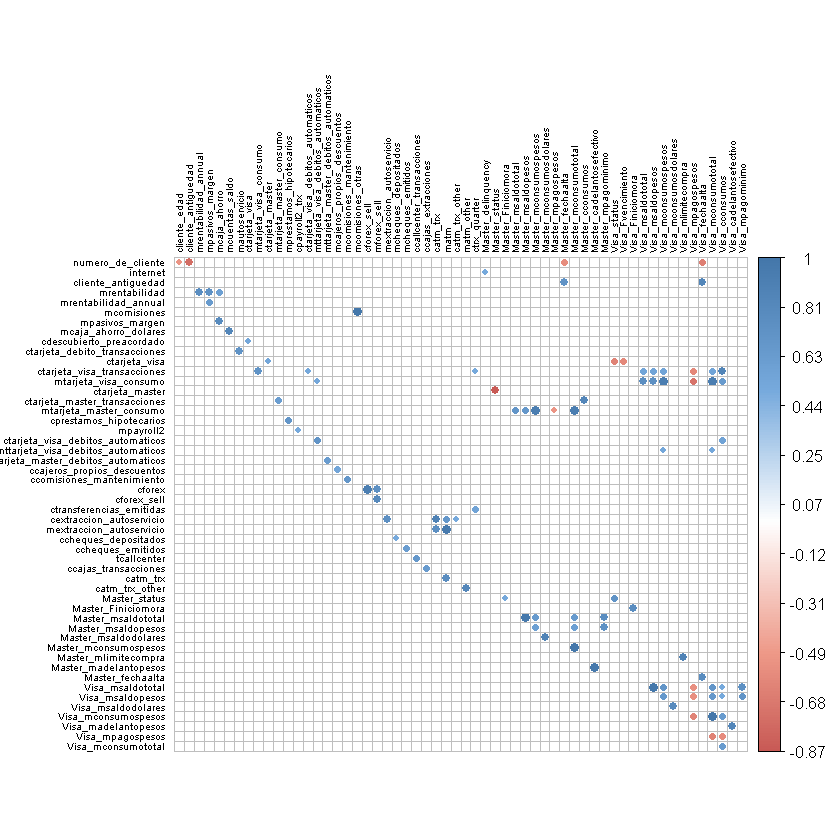

In [34]:
numeric_vars <- names(dataset)[sapply(dataset, is.numeric) | sapply(dataset, is.integer)]
dt_numeric <- dataset[, ..numeric_vars]

# Calcular la matriz de correlación
corr <- cor(dt_numeric, use = "pairwise.complete.obs")

sig <- 0.5 #Nivel de significancia
#Elimino duplicados
corr[lower.tri(corr, diag=FALSE)] <- NA 
# Elimino la diagonal
diag(corr) <- NA 

# Si quisiera eliminar correlaciones perfectas:
# corr[corr == 1] <- NA 

# Convierto a dataframe
corr <- as.data.frame(as.table(corr))

# Remuevo na para evitar errores
corr <- na.omit(corr) 

# Valores significativos
corr_significant <- subset(corr, abs(Freq) > sig) 

# Ordeno por mayor correlacion
corr_order <- corr_significant[order(-abs(corr_significant$Freq)),] 

# Lo vuelvo a transformar en matriz para hacer el corrplot
mtx_corr <- reshape2::acast(corr_order, Var1~Var2, value.var="Freq")

corrplot(mtx_corr, 
        is.corr = FALSE, 
        method = "circle",           # Usar método de color para mejor visualización
        tl.col = "black",           # Color de las etiquetas
        tl.cex = 0.5,              # Tamaño de fuente de las etiquetas (más pequeño)
        na.label = " ",
        col = colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", 
                                "#77AADD", "#4477AA"))(200),  # Paleta de colores más clara
)


--- Correlación con clase_ternaria ---
                                                           Variable Correlation
foto_mes                                                   foto_mes -0.82539154
Master_Finiciomora                               Master_Finiciomora -0.22131038
Master_fultimo_cierre                         Master_fultimo_cierre -0.11067523
Visa_fultimo_cierre                             Visa_fultimo_cierre -0.10624898
ccajas_depositos                                   ccajas_depositos  0.07401895
cpayroll_trx                                           cpayroll_trx -0.05544598
cmobile_app_trx                                     cmobile_app_trx -0.04419880
Visa_mpagado                                           Visa_mpagado -0.04279967
ccajas_otras                                           ccajas_otras -0.04056611
mtarjeta_visa_consumo                         mtarjeta_visa_consumo -0.04054602
ctransferencias_emitidas                   ctransferencias_emitidas -0.03827069


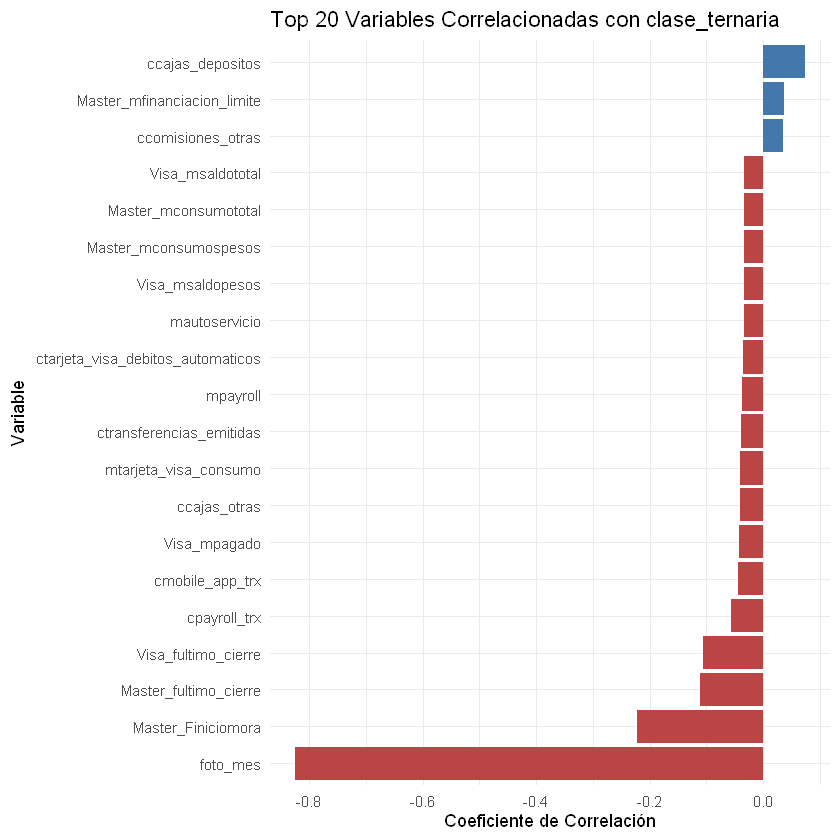

In [35]:
# --- Correlación con clase_ternaria ---
# 1. Crear una copia del dataset para no modificar el original
dt_corr_target <- copy(dataset)

# 2. Convertir 'clase_ternaria' a una variable numérica
# as.factor la convierte en factor, y as.numeric le asigna un entero a cada nivel
dt_corr_target[, clase_ternaria_num := as.numeric(as.factor(clase_ternaria))]

# 3. Calcular la correlación de cada variable numérica con 'clase_ternaria_num'
correlations_with_target <- sapply(numeric_vars, function(var) {
  # Usamos 'pairwise.complete.obs' para manejar NAs
  cor(dt_corr_target[[var]], dt_corr_target$clase_ternaria_num, use = "pairwise.complete.obs")
})

# 4. Crear un data.frame con los resultados y ordenarlo
corr_target_df <- data.frame(
  Variable = names(correlations_with_target),
  Correlation = correlations_with_target
)
corr_target_df <- corr_target_df[order(-abs(corr_target_df$Correlation)), ]
corr_target_df <- na.omit(corr_target_df) # Eliminar NAs si alguna correlación no se pudo calcular

# 5. Mostrar las variables más correlacionadas con clase_ternaria
cat("\n--- Correlación con clase_ternaria ---\n")
print(head(corr_target_df, 20))

# 6. Graficar las correlaciones más importantes con clase_ternaria
ggplot(head(corr_target_df, 20), aes(x = reorder(Variable, Correlation), y = Correlation)) +
  geom_bar(stat = "identity", aes(fill = Correlation > 0)) +
  coord_flip() +
  scale_fill_manual(values = c("TRUE" = "#4477AA", "FALSE" = "#BB4444"), guide = "none") +
  labs(
    title = "Top 20 Variables Correlacionadas con clase_ternaria",
    x = "Variable",
    y = "Coeficiente de Correlación"
  ) +
  theme_minimal()

# Cluster

In [36]:
# Me quedo solo con los campos feature
features <- copy(setdiff(colnames(dataset), c("clase_ternaria")))

#me quedo con los registros que no son CONTINUA
dataset_baja <- dataset[dataset$clase_ternaria=='BAJA+2']

# la libreria randomForest no procesa nativamente los datos faltantes para su entrenamiento
dataset_baja  <-  na.roughfix(dataset_baja)

set.seed(PARAM$semilla_primigenia)

In [37]:
# entrenamiento del modelo
modelo <- randomForest(dataset_baja[,..features], y=NULL, ntree = 2500, proximity=TRUE, oob.prox = TRUE)

# obtenemos la matriz de proximidades
proximidades <- modelo$proximity

# La convierto en una matriz de distancia/disimilitud
distancias <- as.dist(1 - proximidades)

# Realizar clustering utilizando las proximidades
hclust_result <- hclust(distancias,method = "ward.D2")

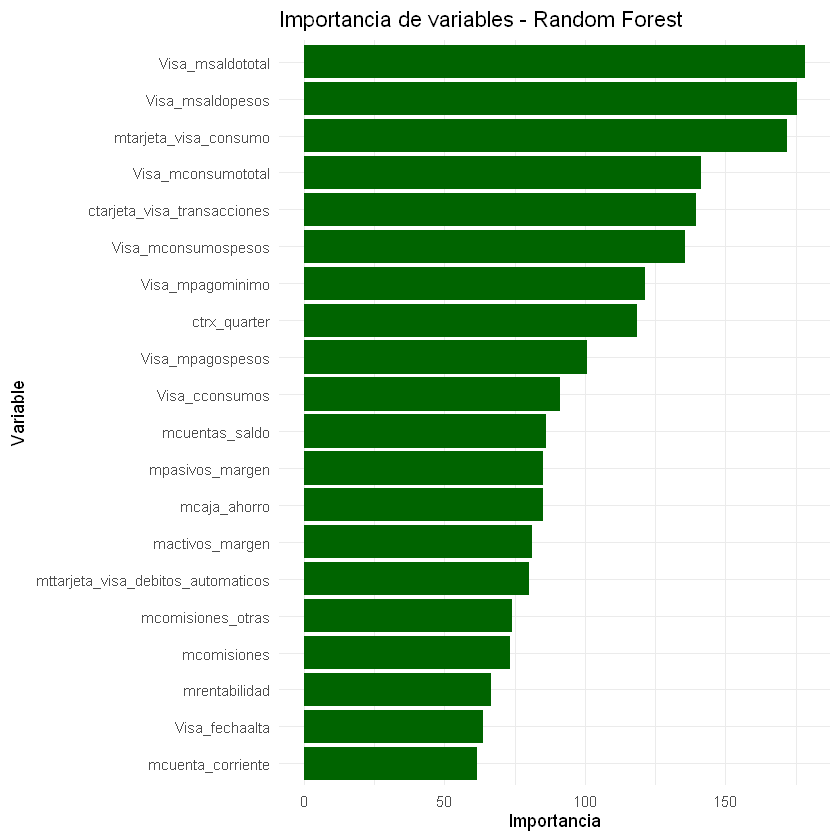

In [38]:
# Obtener importancias
importancia_rf <- as.data.table(importance(modelo), keep.rownames = TRUE)

importancia_rf <- importancia_rf[order(-MeanDecreaseGini)][1:20]

setnames(importancia_rf, "rn", "Variable")

# Usar MeanDecreaseGini como importancia
ggplot(importancia_rf, aes(x = reorder(Variable, MeanDecreaseGini), y = MeanDecreaseGini)) +
  geom_col(fill = "darkgreen") +
  coord_flip() +
  labs(title = "Importancia de variables - Random Forest", x = "Variable", y = "Importancia") +
  theme(axis.title = element_text(size = 5))+
  theme_minimal()

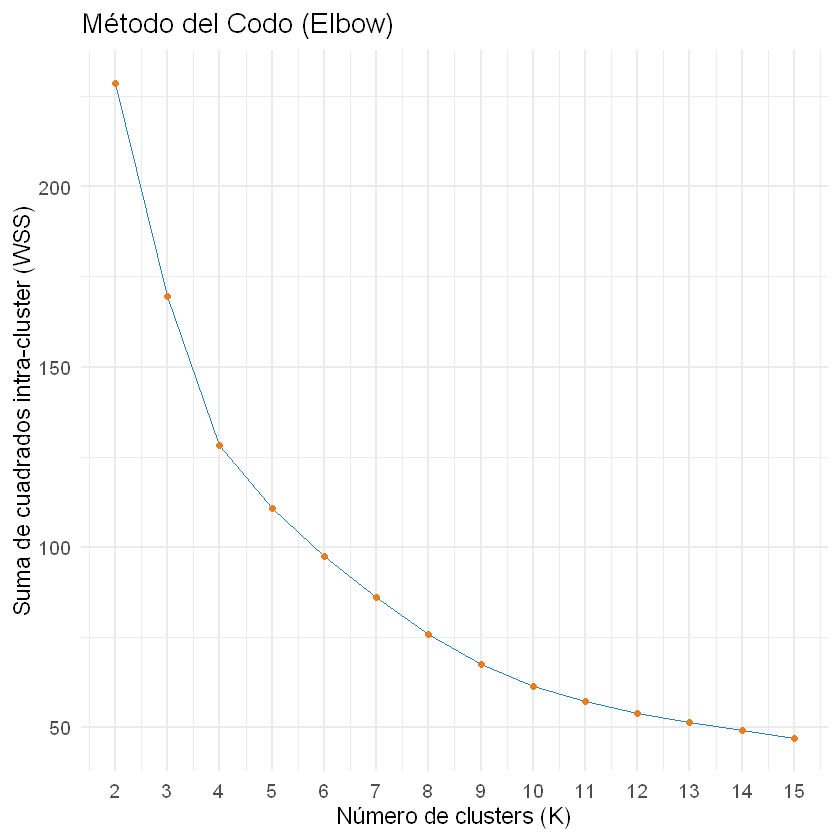

In [39]:
# Reducimos dimensionalidad para k-means (por ejemplo, a 5D)
mds_data <- cmdscale(distancias, k = 5)

# Probamos diferentes K
k_values <- 2:15
wss_values <- sapply(k_values, function(k) {
  kmeans(mds_data, centers = k, nstart = 25, iter.max = 100)$tot.withinss
})

# Data frame para ggplot
elbow_df <- data.frame(K = k_values, WSS = wss_values)

# Gráfico con ggplot2
ggplot(elbow_df, aes(x = K, y = WSS)) +
  geom_line(color = "#2980B9") +
  geom_point(color = "#E67E22") +
  scale_x_continuous(breaks = k_values) +
  labs(
    title = "Método del Codo (Elbow)",
    x = "Número de clusters (K)",
    y = "Suma de cuadrados intra-cluster (WSS)"
  ) +
  theme_minimal(base_size = 14)


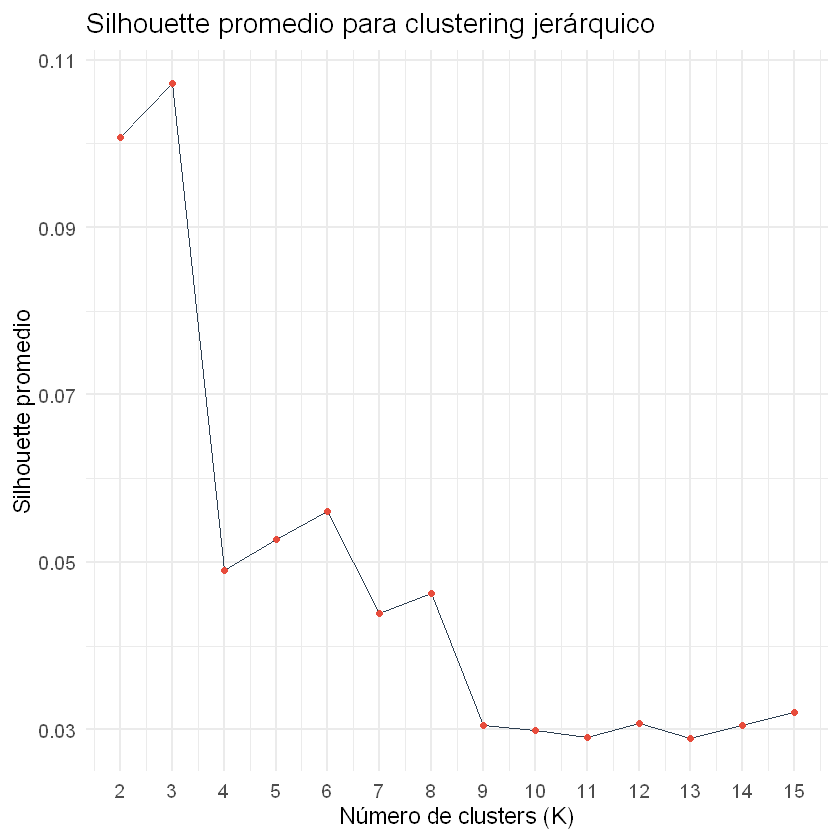

In [40]:
# Rango de clusters a evaluar
k_values <- 2:15

# Calculamos el silhouette promedio para cada k
sil_scores <- sapply(k_values, function(k) {
  clusters <- cutree(hclust_result, k = k)
  sil <- silhouette(clusters, distancias)
  mean(sil[, 3])
})

# Grafico
sil_df <- data.frame(
  K = k_values,
  Silhouette = sil_scores
)

ggplot(sil_df, aes(x = K, y = Silhouette)) +
  geom_line(color = "#2C3E50") +
  geom_point(color = "#E74C3C") +
  scale_x_continuous(breaks = k_values) +
  labs(
    title = "Silhouette promedio para clustering jerárquico",
    x = "Número de clusters (K)",
    y = "Silhouette promedio"
  ) +
  theme_minimal(base_size = 14)

Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 itera

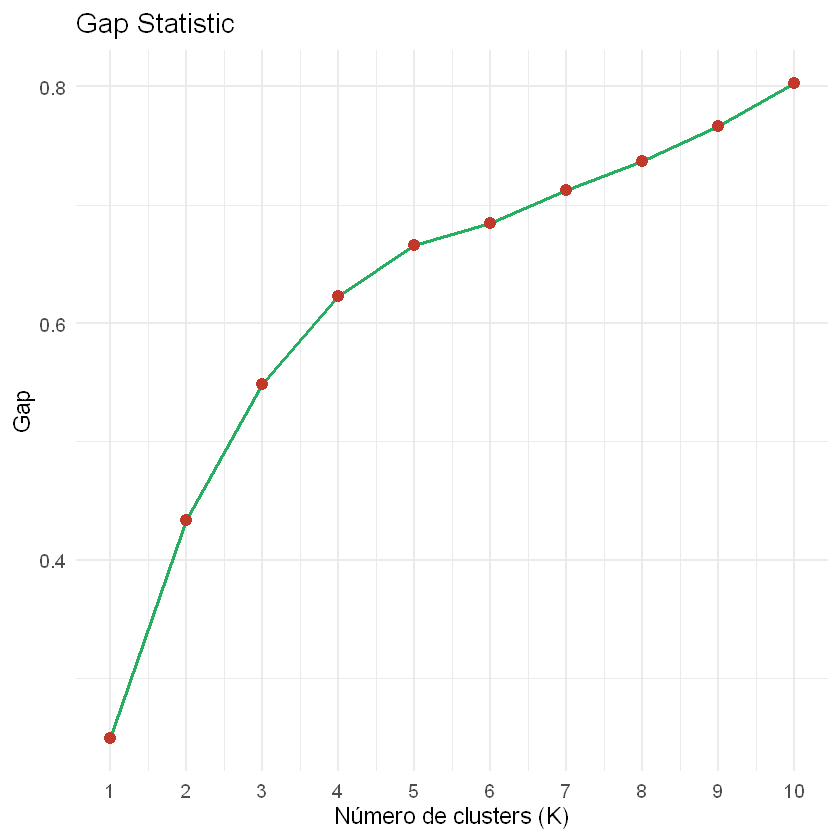

In [41]:
# Calcular el gap statistic
gap_stat <- clusGap(mds_data, FUN = kmeans, nstart = 10, K.max = 10, B = 50)

# Convertimos a data.frame para ggplot
gap_df <- as.data.frame(gap_stat$Tab)
gap_df$K <- 1:nrow(gap_df)

# Gráfico de Gap Statistic
ggplot(gap_df, aes(x = K, y = gap)) +
  geom_line(color = "#27AE60", size = 1) +
  geom_point(color = "#C0392B", size = 3) +
  scale_x_continuous(breaks = gap_df$K) +
  labs(
    title = "Gap Statistic",
    x = "Número de clusters (K)",
    y = "Gap"
  ) +
  theme_minimal(base_size = 14)


In [42]:
for (k in 2:15) {
  cl <- cutree(hclust_result, k)
  ari <- adjustedRandIndex(cl, dataset_baja$clase_ternaria)
  cat("K =", k, "ARI =", round(ari, 4), "\n")
}

K = 2 ARI = 0 
K = 3 ARI = 0 
K = 4 ARI = 0 
K = 5 ARI = 0 
K = 6 ARI = 0 
K = 7 ARI = 0 
K = 8 ARI = 0 
K = 9 ARI = 0 
K = 10 ARI = 0 
K = 11 ARI = 0 
K = 12 ARI = 0 
K = 13 ARI = 0 
K = 14 ARI = 0 
K = 15 ARI = 0 


In [ ]:
# ========== FUNCIÓN PRINCIPAL: EVALUAR K ÓPTIMO ==========

evaluate_optimal_k <- function(hclust_result, distancias, max_k = 20) {
  
  cat("=== EVALUANDO K ÓPTIMO ===\n")
  cat("Registros:", attr(distancias, "Size"), "\n")
  cat("Evaluando K de 2 a", max_k, "\n")
  cat("Timestamp:", Sys.time(), "\n\n")
  
  # Inicializar tabla de resultados
  results <- data.frame(
    k = 2:max_k,
    silhouette = NA,
    wss = NA,
    gap = NA
  )
  
  total_k <- max_k - 1
  
  # MÉTODO 1: SILHOUETTE
  cat("📊 Calculando Silhouette Score...\n")
  for(i in 1:total_k) {
    k <- i + 1
    cat(sprintf("   K=%d (%d/%d) - %.1f%%\r", k, i, total_k, (i/total_k)*100))
    
    clusters <- cutree(hclust_result, k = k)
    sil <- silhouette(clusters, distancias)
    results$silhouette[i] <- mean(sil[, 3])
  }
  cat("\n✅ Silhouette completado\n\n")
  
  # MÉTODO 2: WITHIN SUM OF SQUARES (WSS)
  cat("📐 Calculando Within Sum of Squares...\n")
  for(i in 1:total_k) {
    k <- i + 1
    cat(sprintf("   K=%d (%d/%d) - %.1f%%\r", k, i, total_k, (i/total_k)*100))
    
    clusters <- cutree(hclust_result, k = k)
    
    # Calcular WSS
    wss <- 0
    for(cluster_id in 1:k) {
      cluster_points <- which(clusters == cluster_id)
      if(length(cluster_points) > 1) {
        cluster_dist_matrix <- as.matrix(distancias)[cluster_points, cluster_points]
        wss <- wss + sum(cluster_dist_matrix^2) / (2 * length(cluster_points))
      }
    }
    results$wss[i] <- wss
  }
  cat("\n✅ WSS completado\n\n")
  
  # MÉTODO 3: GAP STATISTIC (simplificado para eficiencia)
  cat("📈 Calculando Gap Statistic...\n")
  
  # Función auxiliar para calcular WSS de referencia
  reference_wss <- function(data_points, k) {
    # Generar datos aleatorios uniformes en el mismo rango
    n_points <- nrow(data_points)
    random_data <- matrix(runif(n_points * ncol(data_points)), nrow = n_points)
    
    # Clustering en datos aleatorios
    random_dist <- dist(random_data)
    random_hc <- hclust(random_dist, method = "ward.D2")
    random_clusters <- cutree(random_hc, k = k)
    
    # Calcular WSS
    wss_ref <- 0
    for(cluster_id in 1:k) {
      cluster_points <- which(random_clusters == cluster_id)
      if(length(cluster_points) > 1) {
        cluster_dist_matrix <- as.matrix(random_dist)[cluster_points, cluster_points]
        wss_ref <- wss_ref + sum(cluster_dist_matrix^2) / (2 * length(cluster_points))
      }
    }
    return(log(wss_ref))
  }
  
  # Para Gap statistic necesitamos los datos originales en formato matriz
  # Usamos una aproximación basada en las distancias
  n_bootstrap <- 20  # Reducido para eficiencia
  
  for(i in 1:total_k) {
    k <- i + 1
    cat(sprintf("   K=%d (%d/%d) - %.1f%%\r", k, i, total_k, (i/total_k)*100))
    
    # WSS observado (ya lo tenemos)
    wss_obs <- log(results$wss[i])
    
    # WSS esperado bajo H0 (datos aleatorios)
    # Aproximación: usar distribución de distancias para generar referencias
    set.seed(123)
    wss_refs <- replicate(n_bootstrap, {
      # Generar matriz aleatoria con propiedades similares
      n <- attr(distancias, "Size")
      random_matrix <- matrix(runif(n * 10), nrow = n)  # 10 dimensiones arbitrarias
      random_dist <- dist(random_matrix)
      random_hc <- hclust(random_dist, method = "ward.D2")
      random_clusters <- cutree(random_hc, k = k)
      
      wss_ref <- 0
      for(cluster_id in 1:k) {
        cluster_points <- which(random_clusters == cluster_id)
        if(length(cluster_points) > 1) {
          cluster_dist_matrix <- as.matrix(random_dist)[cluster_points, cluster_points]
          wss_ref <- wss_ref + sum(cluster_dist_matrix^2) / (2 * length(cluster_points))
        }
      }
      return(log(wss_ref))
    })
    
    # Gap = promedio(log(WSS_ref)) - log(WSS_obs)
    results$gap[i] <- mean(wss_refs) - wss_obs
  }
  cat("\n✅ Gap Statistic completado\n\n")
  
  return(results)
}

# ========== FUNCIÓN PARA CREAR GRÁFICOS ==========

plot_optimal_k <- function(results) {
  
  cat("📊 Creando gráficos...\n")
  
  # Encontrar óptimos
  best_k_sil <- results$k[which.max(results$silhouette)]
  
  # Método del codo para WSS
  wss_diffs <- diff(results$wss)
  wss_second_diffs <- diff(wss_diffs)
  best_k_elbow <- results$k[which.max(abs(wss_second_diffs)) + 1]
  
  # Gap statistic
  best_k_gap <- results$k[which.max(results$gap)]
  
  # GRÁFICO 1: SILHOUETTE
  p1 <- ggplot(results, aes(x = k, y = silhouette)) +
    geom_line(color = "blue", size = 1) +
    geom_point(color = "blue", size = 2) +
    geom_vline(xintercept = best_k_sil, color = "red", linetype = "dashed", alpha = 0.7) +
    geom_point(data = results[results$k == best_k_sil,], 
               aes(x = k, y = silhouette), color = "red", size = 4) +
    labs(title = paste("Silhouette Score\nÓptimo K =", best_k_sil),
         x = "Número de Clusters (K)",
         y = "Silhouette Score Promedio") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5))
  
  # GRÁFICO 2: WSS (MÉTODO DEL CODO)
  p2 <- ggplot(results, aes(x = k, y = wss)) +
    geom_line(color = "green", size = 1) +
    geom_point(color = "green", size = 2) +
    geom_vline(xintercept = best_k_elbow, color = "red", linetype = "dashed", alpha = 0.7) +
    geom_point(data = results[results$k == best_k_elbow,], 
               aes(x = k, y = wss), color = "red", size = 4) +
    labs(title = paste("Método del Codo (WSS)\nÓptimo K =", best_k_elbow),
         x = "Número de Clusters (K)",
         y = "Within Sum of Squares") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5))
  
  # GRÁFICO 3: GAP STATISTIC
  p3 <- ggplot(results, aes(x = k, y = gap)) +
    geom_line(color = "purple", size = 1) +
    geom_point(color = "purple", size = 2) +
    geom_vline(xintercept = best_k_gap, color = "red", linetype = "dashed", alpha = 0.7) +
    geom_point(data = results[results$k == best_k_gap,], 
               aes(x = k, y = gap), color = "red", size = 4) +
    labs(title = paste("Gap Statistic\nÓptimo K =", best_k_gap),
         x = "Número de Clusters (K)",
         y = "Gap Statistic") +
    theme_minimal() +
    theme(plot.title = element_text(hjust = 0.5))
  
  # COMBINAR GRÁFICOS
  combined_plot <- grid.arrange(p1, p2, p3, ncol = 2, nrow = 2,
                               top = "Métodos para Determinar K Óptimo")
  
  # MOSTRAR RESULTADOS
  cat("\n=== RESULTADOS FINALES ===\n")
  cat("🏆 Silhouette Score - K óptimo:", best_k_sil, 
      "(valor =", round(max(results$silhouette), 3), ")\n")
  cat("📐 Método del Codo - K óptimo:", best_k_elbow, "\n")
  cat("📈 Gap Statistic - K óptimo:", best_k_gap, 
      "(valor =", round(max(results$gap), 3), ")\n")
  
  # Recomendación basada en consenso
  all_ks <- c(best_k_sil, best_k_elbow, best_k_gap)
  recommendation <- round(median(all_ks))
  
  cat("\n🎯 RECOMENDACIÓN FINAL (mediana):", recommendation, "\n")
  cat("📊 Distribución de recomendaciones:", paste(sort(all_ks), collapse = ", "), "\n")
  
  return(list(
    results = results,
    plots = list(silhouette = p1, elbow = p2, gap = p3, combined = combined_plot),
    best_k = list(silhouette = best_k_sil, elbow = best_k_elbow, gap = best_k_gap),
    recommendation = recommendation
  ))
}

# ========== FUNCIÓN TODO EN UNO ==========

analyze_optimal_k <- function(hclust_result, distancias, max_k = 20) {
  # Evaluar métrica
  results <- evaluate_optimal_k(hclust_result, distancias, max_k)
  
  # Crear gráficos y obtener recomendación
  analysis <- plot_optimal_k(results)
  
  return(analysis)
}


optimal_analysis <- analyze_optimal_k(hclust_result, distancias, max_k = 15)

# Ver la tabla completa de resultados
print(optimal_analysis$results)

# Aplicar el K recomendado
#final_clusters <- cutree(hclust_result, k = optimal_analysis$recommendation)
#dataset_baja$cluster <- final_clusters

In [44]:
final_clusters <- cutree(hclust_result, k = optimal_analysis$recommendation)


In [ ]:
# Rango de clusters a evaluar
k_range <- 2:15

# Recorrer los valores de K y graficar los silhouettes
for (k in k_range) {
  cat("Mostrando gráfico para K =", k, "\n")
  
  # Cortamos el dendrograma
  cluster_assignments <- cutree(hclust_result, k = k)
  
  # Calculamos silhouette
  sil <- silhouette(cluster_assignments, distancias)
 
  # Graficamos silhouette con ggplot
  print(
    fviz_silhouette(sil) +
      labs(title = paste("Gráfico de Silhouette para K =", k))
  )
}

In [ ]:
# Evalúo K óptimo
evaluate_optimal_k <- function(hclust_result, distancias, max_k = 20) {
  cat("--- EVALUANDO K ÓPTIMO ---\n")
  cat("Registros:", attr(distancias, "Size"), "\n")
  cat("Evaluando K de 2 a", max_k, "\n")
  cat("Timestamp:", Sys.time(), "\n\n")
  
  # Cargar librería necesaria para silhouette
  if (!require(cluster, quietly = TRUE)) {
    install.packages("cluster")
    library(cluster)
  }
  
  # Inicializar tabla de resultados
  results <- data.frame(
    k = 2:max_k,
    silhouette = NA,
    wss = NA,
    gap = NA
  )
  
  total_k <- max_k - 1
  
  # MÉTODO 1: SILHOUETTE
  cat("📊 Calculando Silhouette Score...\n")
  for(i in 1:total_k) {
    k <- i + 1
    cat(sprintf("   K=%d (%d/%d) - %.1f%%\r", k, i, total_k, (i/total_k)*100))
    
    clusters <- cutree(hclust_result, k = k)
    sil <- silhouette(clusters, distancias)
    results$silhouette[i] <- mean(sil[, 3])
  }
  cat("\n✅ Silhouette completado\n\n")
  
  # MÉTODO 2: WITHIN SUM OF SQUARES (WSS)
  cat("📐 Calculando Within Sum of Squares...\n")
  for(i in 1:total_k) {
    k <- i + 1
    cat(sprintf("   K=%d (%d/%d) - %.1f%%\r", k, i, total_k, (i/total_k)*100))
    
    clusters <- cutree(hclust_result, k = k)
    
    # Calcular WSS
    wss <- 0
    for(cluster_id in 1:k) {
      cluster_points <- which(clusters == cluster_id)
      if(length(cluster_points) > 1) {
        cluster_dist_matrix <- as.matrix(distancias)[cluster_points, cluster_points]
        wss <- wss + sum(cluster_dist_matrix^2) / (2 * length(cluster_points))
      }
    }
    results$wss[i] <- wss
  }
  cat("\n✅ WSS completado\n\n")
  
  # MÉTODO 3: GAP STATISTIC (simplificado para eficiencia)
  cat("📈 Calculando Gap Statistic...\n")
  
  # Para Gap statistic necesitamos los datos originales en formato matriz
  # Usamos una aproximación basada en las distancias
  n_bootstrap <- 20  # Reducido para eficiencia
  
  for(i in 1:total_k) {
    k <- i + 1
    cat(sprintf("   K=%d (%d/%d) - %.1f%%\r", k, i, total_k, (i/total_k)*100))
    
    # WSS observado (ya lo tenemos)
    wss_obs <- log(results$wss[i])
    
    # WSS esperado bajo H0 (datos aleatorios)
    # Aproximación: usar distribución de distancias para generar referencias
    set.seed(123)
    wss_refs <- replicate(n_bootstrap, {
      # Generar matriz aleatoria con propiedades similares
      n <- attr(distancias, "Size")
      random_matrix <- matrix(runif(n * 10), nrow = n)  # 10 dimensiones arbitrarias
      random_dist <- dist(random_matrix)
      random_hc <- hclust(random_dist, method = "ward.D2")
      random_clusters <- cutree(random_hc, k = k)
      
      wss_ref <- 0
      for(cluster_id in 1:k) {
        cluster_points <- which(random_clusters == cluster_id)
        if(length(cluster_points) > 1) {
          cluster_dist_matrix <- as.matrix(random_dist)[cluster_points, cluster_points]
          wss_ref <- wss_ref + sum(cluster_dist_matrix^2) / (2 * length(cluster_points))
        }
      }
      return(log(wss_ref))
    })
    
    # Gap = promedio(log(WSS_ref)) - log(WSS_obs)
    results$gap[i] <- mean(wss_refs) - wss_obs
  }
  cat("\n✅ Gap Statistic completado\n\n")
  
  return(results)
}


# Me quedo solo con los campos feature
features <- copy(setdiff(colnames(dataset), c("clase_ternaria")))

#me quedo con los registros que no son CONTINUA
dataset_baja <- dataset[dataset$clase_ternaria=='BAJA+2']

# la libreria randomForest no procesa nativamente los datos faltantes para su entrenamiento
dataset_baja  <-  na.roughfix(dataset_baja)

set.seed(PARAM$semilla_primigenia)

# entrenamiento del modelo
cat("--- Entrenamiento Random Forest ---\n")
cat("ntree: ",PARAM$ntree, "\n")
modelo <- randomForest(dataset_baja[,..features], y=NULL, ntree = PARAM$ntree, proximity=TRUE, oob.prox = TRUE)

# obtenemos la matriz de proximidades
proximidades <- modelo$proximity

# La convierto en una matriz de distancia/disimilitud
distancias <- as.dist(1 - proximidades)

# Realizar clustering utilizando las proximidades
hclust_result <- hclust(distancias,method = "ward.D2")

# Obtener importancias
importancia_rf <- as.data.table(importance(modelo), keep.rownames = TRUE)
# Ordenar por importancia (MeanDecreaseGini es la métrica por defecto en randomForest)
importancia_rf <- importancia_rf[order(-MeanDecreaseGini)]


# Determinar número óptimo de clusters usando la función completa
cat("--- Evaluando número óptimo de clústeres ---")
resultados_k <- evaluate_optimal_k(hclust_result, distancias, max_k = 15)

# Silhouette
best_k_sil <- resultados_k$k[which.max(resultados_k$silhouette)]

# Método del codo para WSS
wss_diffs <- diff(resultados_k$wss)
wss_second_diffs <- diff(wss_diffs)
best_k_elbow <- resultados_k$k[which.max(abs(wss_second_diffs)) + 1]

# Gap statistic
best_k_gap <- resultados_k$k[which.max(resultados_k$gap)]

# Elijo el mejor
all_ks <- c(best_k_sil, best_k_elbow, best_k_gap)
mejor_cluster <- round(median(all_ks))

# Clusters para comparación: mejor_cluster-1 y mejor_cluster+1
cluster_abajo <- mejor_cluster - 1
cluster_arriba <- mejor_cluster + 1

# Ajustar si nos salimos del rango
if (cluster_arriba > max_cluster) {
  cluster_arriba <- max_cluster
}

if (cluster_abajo < 1) {
  cluster_abajo <- 1
}

# Si solo tenemos 2 clusters, ajustamos
if (num_clusters == 2) {
  mejor_cluster <- 2
  cluster_abajo <- 1
  cluster_arriba <- 2
}

# Si solo tenemos 1 cluster (caso edge)
if (num_clusters == 1) {
  mejor_cluster <- 1
  cluster_abajo <- 1
  cluster_arriba <- 1
}

clusters_interes <- c(cluster_abajo, mejor_cluster, cluster_arriba)
clusters_interes <- unique(clusters_interes)

for (k in clusters_interes){
  clusters <- cutree(hclust_result, k = k)
  dataset_baja[,paste0("labels_",k):= clusters]
}

# Analisis final

In [5]:
# Evalúo K óptimo
evaluate_optimal_k <- function(hclust_result, distancias, max_k = 20) {
  cat("--- EVALUANDO K ÓPTIMO ---\n")
  cat("Registros:", attr(distancias, "Size"), "\n")
  cat("Evaluando K de 2 a", max_k, "\n")
  cat("Timestamp:", Sys.time(), "\n\n")
  
  # Cargar librería necesaria para silhouette
  if (!require(cluster, quietly = TRUE)) {
    install.packages("cluster")
    library(cluster)
  }
  
  # Inicializar tabla de resultados
  results <- data.frame(
    k = 2:max_k,
    silhouette = NA,
    wss = NA,
    gap = NA
  )
  
  total_k <- max_k - 1
  
  # MÉTODO 1: SILHOUETTE
  cat("📊 Calculando Silhouette Score...\n")
  for(i in 1:total_k) {
    k <- i + 1
    cat(sprintf("   K=%d (%d/%d) - %.1f%%\r", k, i, total_k, (i/total_k)*100))
    
    clusters <- cutree(hclust_result, k = k)
    sil <- silhouette(clusters, distancias)
    results$silhouette[i] <- mean(sil[, 3])
  }
  cat("\n✅ Silhouette completado\n\n")
  
  # MÉTODO 2: WITHIN SUM OF SQUARES (WSS)
  cat("📐 Calculando Within Sum of Squares...\n")
  for(i in 1:total_k) {
    k <- i + 1
    cat(sprintf("   K=%d (%d/%d) - %.1f%%\r", k, i, total_k, (i/total_k)*100))
    
    clusters <- cutree(hclust_result, k = k)
    
    # Calcular WSS
    wss <- 0
    for(cluster_id in 1:k) {
      cluster_points <- which(clusters == cluster_id)
      if(length(cluster_points) > 1) {
        cluster_dist_matrix <- as.matrix(distancias)[cluster_points, cluster_points]
        wss <- wss + sum(cluster_dist_matrix^2) / (2 * length(cluster_points))
      }
    }
    results$wss[i] <- wss
  }
  cat("\n✅ WSS completado\n\n")
  
  # MÉTODO 3: GAP STATISTIC (simplificado para eficiencia)
  cat("📈 Calculando Gap Statistic...\n")
  
  # Para Gap statistic necesitamos los datos originales en formato matriz
  # Usamos una aproximación basada en las distancias
  n_bootstrap <- 20  # Reducido para eficiencia
  
  for(i in 1:total_k) {
    k <- i + 1
    cat(sprintf("   K=%d (%d/%d) - %.1f%%\r", k, i, total_k, (i/total_k)*100))
    
    # WSS observado (ya lo tenemos)
    wss_obs <- log(results$wss[i])
    
    # WSS esperado bajo H0 (datos aleatorios)
    # Aproximación: usar distribución de distancias para generar referencias
    set.seed(123)
    wss_refs <- replicate(n_bootstrap, {
      # Generar matriz aleatoria con propiedades similares
      n <- attr(distancias, "Size")
      random_matrix <- matrix(runif(n * 10), nrow = n)  # 10 dimensiones arbitrarias
      random_dist <- dist(random_matrix)
      random_hc <- hclust(random_dist, method = "ward.D2")
      random_clusters <- cutree(random_hc, k = k)
      
      wss_ref <- 0
      for(cluster_id in 1:k) {
        cluster_points <- which(random_clusters == cluster_id)
        if(length(cluster_points) > 1) {
          cluster_dist_matrix <- as.matrix(random_dist)[cluster_points, cluster_points]
          wss_ref <- wss_ref + sum(cluster_dist_matrix^2) / (2 * length(cluster_points))
        }
      }
      return(log(wss_ref))
    })
    
    # Gap = promedio(log(WSS_ref)) - log(WSS_obs)
    results$gap[i] <- mean(wss_refs) - wss_obs
  }
  cat("\n✅ Gap Statistic completado\n\n")
  
  return(results)
}

# Me quedo solo con los campos feature
features <- copy(setdiff(colnames(dataset), c("clase_ternaria")))

#me quedo con los registros que no son CONTINUA
dataset_baja <- dataset[dataset$clase_ternaria=='BAJA+2']

# la libreria randomForest no procesa nativamente los datos faltantes para su entrenamiento
dataset_baja  <-  na.roughfix(dataset_baja)

set.seed(PARAM$semilla_primigenia)

# entrenamiento del modelo
cat("--- Entrenamiento Random Forest ---\n")
cat("ntree: ",PARAM$ntree, "\n")
modelo <- randomForest(dataset_baja[,..features], y=NULL, ntree = PARAM$ntree, proximity=TRUE, oob.prox = TRUE)

# obtenemos la matriz de proximidades
proximidades <- modelo$proximity

# La convierto en una matriz de distancia/disimilitud
distancias <- as.dist(1 - proximidades)

# Realizar clustering utilizando las proximidades
hclust_result <- hclust(distancias,method = "ward.D2")

# Obtener importancias
importancia_rf <- as.data.table(importance(modelo), keep.rownames = TRUE)
# Ordenar por importancia (MeanDecreaseGini es la métrica por defecto en randomForest)
importancia_rf <- importancia_rf[order(-MeanDecreaseGini)]

# Determinar número óptimo de clusters usando la función completa
cat("--- Evaluando número óptimo de clústeres ---")
resultados_k <- evaluate_optimal_k(hclust_result, distancias, max_k = 15)

# Silhouette
best_k_sil <- resultados_k$k[which.max(resultados_k$silhouette)]

# Método del codo para WSS
wss_diffs <- diff(resultados_k$wss)
wss_second_diffs <- diff(wss_diffs)
best_k_elbow <- resultados_k$k[which.max(abs(wss_second_diffs)) + 1]

# Gap statistic
best_k_gap <- resultados_k$k[which.max(resultados_k$gap)]

# Elijo el mejor
all_ks <- c(best_k_sil, best_k_elbow, best_k_gap)
mejor_cluster <- round(median(all_ks))

# Clusters para comparación: mejor_cluster-1 y mejor_cluster+1
cluster_abajo <- mejor_cluster - 1
cluster_arriba <- mejor_cluster + 1

# Ajustar si nos salimos del rango
max_cluster <- 15  # definir max_cluster
if (cluster_arriba > max_cluster) {
  cluster_arriba <- max_cluster
}

if (cluster_abajo < 2) {
  cluster_abajo <- 2
}

# Variables de número de clusters
num_clusters <- nrow(dataset_baja)  # Ajustar según contexto

# Si solo tenemos 2 clusters, ajustamos
if (num_clusters == 2) {
  mejor_cluster <- 2
  cluster_abajo <- 2
  cluster_arriba <- 2
}

# Si solo tenemos 1 cluster (caso edge)
if (num_clusters == 1) {
  mejor_cluster <- 2
  cluster_abajo <- 2
  cluster_arriba <- 2
}

clusters_interes <- c(cluster_abajo, mejor_cluster, cluster_arriba,cluster_arriba+1)
clusters_interes <- unique(clusters_interes)

for (k in clusters_interes){ # modificarlo a gusto, dependiendo de cuántos clústers prefieren obtener
  clusters <- cutree(hclust_result, k = k)
  dataset_baja[,paste0("labels_",k):= clusters]
}

# Dataset histórico para cada cluster
historicos_clusters <- list()

for (k in clusters_interes) {
  
  cluster_col <- paste0("labels_", k)
  
  # Historia de clientes con esa etiqueta
  dataset_baja[, mes_baja := foto_mes + 2]
  
  historico <- dataset[numero_de_cliente %in% unique(dataset_baja$numero_de_cliente)]
  
  historico <- merge(historico, dataset_baja[, .(numero_de_cliente, mes_baja, label = get(cluster_col))], 
                     by = "numero_de_cliente")
  
  historico[, meses_hasta_baja := foto_mes - mes_baja]
  historico <- historico[meses_hasta_baja < 0 & foto_mes < 202105]
  
  historicos_clusters[[cluster_col]] <- historico
}

N <- 15  # Features importantes

variables_mas_importantes <- importancia_rf$rn[1:N]
variables_menos_importantes <- tail(importancia_rf$rn, N)

variables_interes <- c(variables_mas_importantes, variables_menos_importantes)

graficar_variable <- function(data, variable, label_col, importancia) {
  
  resumen <- data[, .(media = mean(get(variable), na.rm = TRUE)), by = .(meses_hasta_baja, label)]
  
  titulo <- paste0(variable, " (", importancia, ")")
  
  p <- ggplot(resumen, aes(x = meses_hasta_baja, y = media, group = label, color = as.factor(label))) +
    geom_line(size = 1) +
    labs(title = titulo, x = "meses_hasta_baja", y = "media", color = "Etiqueta") +
    theme_minimal()
  
  return(p)
}

resumen_paginas <- list()

for (k in clusters_interes) {
  label_col <- paste0("labels_", k)
  historico <- historicos_clusters[[label_col]]
  
  resumen <- historico[, .N, by = label]
  resumen <- resumen[order(label)]
  resumen$text <- paste0("Etiqueta ", resumen$label, ": ", resumen$N, " registros")
  resumen_paginas[[label_col]] <- resumen
}

# Configuración del PDF
nombre_pdf <- paste0("analisis_clusters_", format(Sys.time(), "%Y%m%d_%H%M%S"), ".pdf")
pdf(nombre_pdf, width = 18, height = 10)

# Página 1: Resumen
grid.newpage()
pushViewport(viewport(layout = grid.layout(length(clusters_interes), 1)))

for (i in seq_along(clusters_interes)) {
  k <- clusters_interes[i]
  label_col <- paste0("labels_", k)
  resumen <- resumen_paginas[[label_col]]
  text <- paste(resumen$text, collapse = "\n")
  
  grid.text(paste("Resumen para", label_col, "\n", text),
            vp = viewport(layout.pos.row = i, layout.pos.col = 1),
            gp = gpar(fontsize = 14))
}

# --- Generar todos los gráficos y organizarlos en páginas ---

# Crear lista de listas: cada elemento son 4 gráficos (uno por cluster) para una variable
todos_los_graficos <- list()

for (var in variables_interes) {
  
  # Determinar si es importante o no
  importancia <- if (var %in% variables_mas_importantes) {
    "IMPORTANTE"
  } else {
    "POCO IMPORTANTE"
  }
  
  fila_de_graficos <- list()
  for (k in clusters_interes) {
    label_col <- paste0("labels_", k)
    historico <- historicos_clusters[[label_col]]
    
    p <- graficar_variable(historico, var, label_col, importancia)
    fila_de_graficos[[length(fila_de_graficos) + 1]] <- p
  }
  
  todos_los_graficos[[length(todos_los_graficos) + 1]] <- fila_de_graficos
}

# Agrupar cada 2 filas (es decir, 2 x 3 gráficos por página)
grupos_de_2_filas <- split(todos_los_graficos, ceiling(seq_along(todos_los_graficos) / 2))

# Iterar por páginas
for (pagina in grupos_de_2_filas) {
  plots <- do.call(c, pagina)  # aplanar lista de 2 filas x 3 plots
  grid.arrange(grobs = plots, ncol = 4, nrow = 2)
}

dev.off()

--- Entrenamiento Random Forest ---
ntree:  2500 
--- Evaluando número óptimo de clústeres ------ EVALUANDO K ÓPTIMO ---
Registros: 3938 
Evaluando K de 2 a 15 
Timestamp: 1758222202 

📊 Calculando Silhouette Score...
   K=15 (14/14) - 100.0%
✅ Silhouette completado

📐 Calculando Within Sum of Squares...
   K=15 (14/14) - 100.0%
✅ WSS completado

📈 Calculando Gap Statistic...
   K=15 (14/14) - 100.0%
✅ Gap Statistic completado



Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


pdf 
  2